# Clustering Text in R
----
Contents:

- Part 1: Basics of clustering in R
- Part 2: Project Hierarchial Clustering in R
----

This notebook is inspired from the works of Prof. Ami Gates, Lead Professor, Data Science and CS Department, University of Colorado Boulder (2023)

- Website: https://gatesboltonanalytics.com/?page_id=260

# Part 1: Basics of Clustering in R

## Imports

In [292]:
library(stats)
library(NbClust)
library(cluster)
library(mclust)
library(amap)
library(factoextra)
library(purrr)
#library(stylo)
library(philentropy)
library(SnowballC)
library(caTools)
library(dplyr)
library(textstem)
library(stringr)
library(wordcloud)
library(tm)
library(ggplot2)
library(readr)
library(stringr)
library(igraph)
library(networkD3)

## Dataset (sample)

In [254]:
## Loading collection of documents (.txt files):
corpus = Corpus(DirSource("sampleTweets"))
cat("Number of documents: ", length(corpus))

df = data.frame(tweets = sapply(corpus, as.character), stringsAsFactors = FALSE)
df

Number of documents:  6

,tweets
,<chr>
doc1.txt,CUBoulder is known for its physics department! It's great and has 3 nobel prizes.
doc2.txt,Nobel prize was first awarded in 1901. John Bardeen is the only person to get two awards.
doc3.txt,Nobel prize is named after a Swedish chemist who invented dynamite.
doc4.txt,"Physics has seen numerous nobel prize winners, but my favourite was John Bell who missed it by his sudden death."
doc5.txt,"Invention of dynamite triggered multiple world-changing events and led to discovery of Supersymmetry, the most researched topic in physics."
doc6.txt,"Well, John Bardeen was the only physicist receipient of two awards. The first nobel prize was given in 1901."


## Basic Preprocessing

In [275]:
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeWords, stopwords("english"))
corpus <- tm_map(corpus, lemmatize_strings)

df['cleaned_tweets'] = sapply(corpus, as.character)

## Document-Term and Term-Doc Matrices

In [276]:
## ----------------------------------------------------------------------------------------
## DOCUMENT Term Matrix  (Docs are rows)
## ----------------------------------------------------------------------------------------
Corpus_DTM <- DocumentTermMatrix(
    corpus,
    control = list(stopwords = TRUE, ## remove normal stopwords
                   wordLengths=c(3, 10), ## get rid of words of len 2 or smaller or larger than 15
                   removePunctuation = TRUE,
                   removeNumbers = TRUE,
                   tolower=TRUE
                   #stemming = TRUE,
                  ))

# matrix
Corpus_DTM_mat = data.matrix(Corpus_DTM)

# data-frame
Corpus_DTM_DF = data.frame(Corpus_DTM_mat)

inspect(Corpus_DTM)
(Corpus_DTM_mat)
(Corpus_DTM_DF)

<<DocumentTermMatrix (documents: 6, terms: 39)>>
Non-/sparse entries: 56/178
Sparsity           : 76%
Maximal term length: 10
Weighting          : term frequency (tf)
Sample             :
          Terms
Docs       award bardeen cuboulder dynamite first john nobel physic prize two
  doc1.txt     0       0         1        0     0    0     1      1     1   0
  doc2.txt     2       1         0        0     1    1     1      0     1   1
  doc3.txt     0       0         0        1     0    0     1      0     1   0
  doc4.txt     0       0         0        0     0    1     1      1     1   0
  doc5.txt     0       0         0        1     0    0     0      1     0   0
  doc6.txt     1       1         0        0     1    1     1      0     1   1


,cuboulder,department,great,know,nobel,physic,prize,award,bardeen,first,⋯,invention,lead,multiple,research,topic,trigger,give,good,physicist,receipient
doc1.txt,1,1,1,1,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc2.txt,0,0,0,0,1,0,1,2,1,1,⋯,0,0,0,0,0,0,0,0,0,0
doc3.txt,0,0,0,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc4.txt,0,0,0,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc5.txt,0,0,0,0,0,1,0,0,0,0,⋯,1,1,1,1,1,1,0,0,0,0
doc6.txt,0,0,0,0,1,0,1,1,1,1,⋯,0,0,0,0,0,0,1,1,1,1


,cuboulder,department,great,know,nobel,physic,prize,award,bardeen,first,⋯,invention,lead,multiple,research,topic,trigger,give,good,physicist,receipient
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
doc1.txt,1,1,1,1,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc2.txt,0,0,0,0,1,0,1,2,1,1,⋯,0,0,0,0,0,0,0,0,0,0
doc3.txt,0,0,0,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc4.txt,0,0,0,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
doc5.txt,0,0,0,0,0,1,0,0,0,0,⋯,1,1,1,1,1,1,0,0,0,0
doc6.txt,0,0,0,0,1,0,1,1,1,1,⋯,0,0,0,0,0,0,1,1,1,1


In [277]:
## ----------------------------------------------------------------------------------------
## TERM Document Matrix  (words are rows)
## ----------------------------------------------------------------------------------------
Corpus_TDM <- TermDocumentMatrix(
    corpus,
    control = list(
        stopwords = TRUE, ## remove normal stopwords
        wordLengths=c(3, 10), ## get rid of words of len 2 or smaller or larger than 15
        removePunctuation = TRUE,
        removeNumbers = TRUE,
        tolower=TRUE
        #stemming = TRUE,
        ))

# matrix
Corpus_TDM_mat = data.matrix(Corpus_TDM)

# data-frame
Corpus_TDM_DF <- data.frame(Corpus_TDM_mat)

inspect(Corpus_TDM)
(Corpus_TDM_mat)
(Corpus_TDM_DF)

<<TermDocumentMatrix (terms: 39, documents: 6)>>
Non-/sparse entries: 56/178
Sparsity           : 76%
Maximal term length: 10
Weighting          : term frequency (tf)
Sample             :
           Docs
Terms       doc1.txt doc2.txt doc3.txt doc4.txt doc5.txt doc6.txt
  award            0        2        0        0        0        1
  bardeen          0        1        0        0        0        1
  cuboulder        1        0        0        0        0        0
  dynamite         0        0        1        0        1        0
  first            0        1        0        0        0        1
  john             0        1        0        1        0        1
  nobel            1        1        1        1        0        1
  physic           1        0        0        1        1        0
  prize            1        1        1        1        0        1
  two              0        1        0        0        0        1


,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
cuboulder,1,0,0,0,0,0
department,1,0,0,0,0,0
great,1,0,0,0,0,0
know,1,0,0,0,0,0
nobel,1,1,1,1,0,1
physic,1,0,0,1,1,0
prize,1,1,1,1,0,1
award,0,2,0,0,0,1
bardeen,0,1,0,0,0,1
first,0,1,0,0,0,1


,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cuboulder,1,0,0,0,0,0
department,1,0,0,0,0,0
great,1,0,0,0,0,0
know,1,0,0,0,0,0
nobel,1,1,1,1,0,1
physic,1,0,0,1,1,0
prize,1,1,1,1,0,1
award,0,2,0,0,0,1
bardeen,0,1,0,0,0,1


In [278]:
## ----------------------------------------------------------------------------------------
## VOCABULARY
## ----------------------------------------------------------------------------------------
vocab = unique(Corpus_DTM$dimnames$Terms)
cat("Vocabulary Dimensions (number of unique words): ", length(vocab))

Vocabulary Dimensions (number of unique words):  39

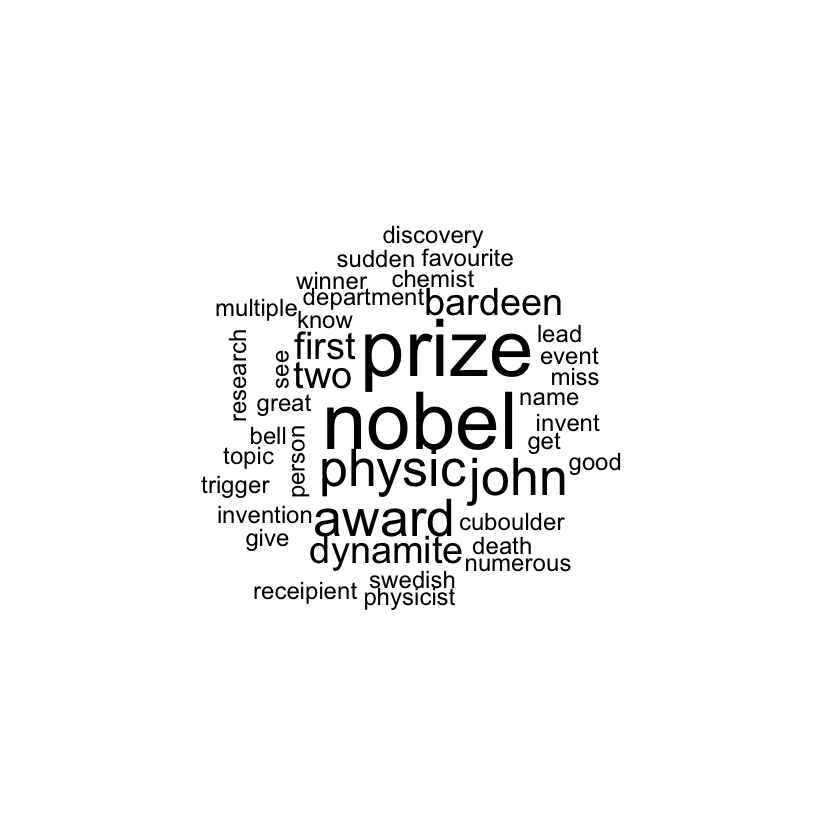

In [279]:
## ----------------------------------------------------------------------------------------
## WORDCLOUD
## ----------------------------------------------------------------------------------------
word.freq <- sort(rowSums(Corpus_TDM_mat), decreasing = T)
wordcloud(words = names(word.freq), freq = word.freq*2, min.freq = 2, random.order = F)

In [280]:
## ----------------------------------------------------------------------------------------
## Get Frequencies and sums
## ----------------------------------------------------------------------------------------
CorpusWordFreq <- colSums(Corpus_DTM_mat)
ord <- order(CorpusWordFreq)

## Word count in each row (doc)
Row_Sum_Per_doc <- rowSums((Corpus_DTM_mat))  

## Normalization
## - Create your own normalization function to divide the frequency of each word in each row 
##   by the sum of the words in that row, using Doc-term-matrix.
Corpus_DTM_mat_norm <- t(apply(Corpus_DTM_mat, 1, function(i) round(i/sum(i),2)))
Corpus_DTM_mat_norm

,cuboulder,department,great,know,nobel,physic,prize,award,bardeen,first,⋯,invention,lead,multiple,research,topic,trigger,give,good,physicist,receipient
doc1.txt,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.00,0.00,0.00,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
doc2.txt,0.00,0.00,0.00,0.00,0.10,0.00,0.10,0.20,0.10,0.10,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
doc3.txt,0.00,0.00,0.00,0.00,0.14,0.00,0.14,0.00,0.00,0.00,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
doc4.txt,0.00,0.00,0.00,0.00,0.08,0.08,0.08,0.00,0.00,0.00,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
doc5.txt,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,⋯,0.1,0.1,0.1,0.1,0.1,0.1,0.00,0.00,0.00,0.00
doc6.txt,0.00,0.00,0.00,0.00,0.09,0.00,0.09,0.09,0.09,0.09,⋯,0.0,0.0,0.0,0.0,0.0,0.0,0.09,0.09,0.09,0.09


## K-Means in R

In [288]:
# #####################################################################
# ## We have many formats of our data:
# ## We have a normalized DTM  :    Corpus_DTM_mat_norm
# ## We have data frame        :    Corpus_DTM_DF
# ## We have matrix            :    Corpus_DTM_mat
# ## We have Term Doc Matrix   :    Corpus_TDM_mat 
# #####################################################################

# ## k means - HOW MANY Clusters?

# #fviz_nbclust(SmallCorpus_DF_DT, method = "silhouette", FUN = hcut, k.max = 9)

# ## k means.............on documents............
# ## transpose the matrix to look at similarity between documents
# SC_DTM_mat_norm_t<-t(SC_DTM_mat_norm)
# kmeans_smallcorp_Result <- kmeans(SC_DTM_mat_norm_t, 4, nstart=25)   

# # Print the results
# print(kmeans_smallcorp_Result)

# kmeans_smallcorp_Result$centers  

# ## Place results in a tbale with the original data
# cbind(SmallCorpus_DF_DT, cluster = kmeans_smallcorp_Result$cluster)

# ## See each cluster
# kmeans_smallcorp_Result$cluster

# ## This is the size (the number of points in) each cluster
# # Cluster size
# kmeans_smallcorp_Result$size
# ## Here we have two clusters, each with 5 points (rows/vectors) 

# ## Visualize the clusters
# fviz_cluster(kmeans_smallcorp_Result, SmallCorpus_DF_DT, 
#              main="Euclidean", repel = TRUE)


# ## k means.............on words............
# #kmeans_smallcorp_Result <- kmeans(SC_DTM_mat_norm, 6, nstart=25) 
# kmeans_smallcorp_Result <- kmeans(t(SmallCorpus_DF_DT), 5, nstart=4) 

# # Print the results
# print(kmeans_smallcorp_Result)

# kmeans_smallcorp_Result$centers  

# ## Place results in a tbale with the original data
# cbind(t(SmallCorpus_DF_DT), cluster = kmeans_smallcorp_Result$cluster)

# ## See each cluster
# kmeans_smallcorp_Result$cluster

# ## This is the size (the number of points in) each cluster
# # Cluster size
# kmeans_smallcorp_Result$size
# ## Here we have two clusters, each with 5 points (rows/vectors) 

# ## Visualize the clusters
# fviz_cluster(kmeans_smallcorp_Result, t(SmallCorpus_DF_DT), 
#              main="Euclidean",repel = TRUE)


# ##########################################################
# ## Let's see if we can do better with Kmeans (not kmeans)
# ## and different distance metrics...
# #########################################################
# ## k = 2
# My_Kmeans_SmallCorp2<-Kmeans(t(SmallCorpus_DF_DT), centers=3 ,method = "euclidean")
# fviz_cluster(My_Kmeans_SmallCorp2, t(SmallCorpus_DF_DT), main="Euclidean k=3",repel = TRUE)

# ## k = 3
# My_Kmeans_SmallCorp3<-Kmeans(t(SmallCorpus_DF_DT), centers=3 ,method = "spearman")
# fviz_cluster(My_Kmeans_SmallCorp3, t(SmallCorpus_DF_DT), main="Spearman", repel = TRUE)

# ## k = 4
# My_Kmeans_SmallCorp4<-Kmeans((SmallCorpus_DF_DT), centers=4 ,method = "spearman")
# fviz_cluster(My_Kmeans_SmallCorp4, t(SmallCorpus_DF_DT), main="Spearman", repel = TRUE)

# ## k = 3 and different metric
# My_Kmeans_SmallCorp4<-Kmeans(t(SmallCorpus_DF_DT), centers=3 ,method = "manhattan")
# fviz_cluster(My_Kmeans_SmallCorp4, t(SmallCorpus_DF_DT), main="manhattan", repel = TRUE)

# ## k = 5 and different metric
# My_Kmeans_SmallCorp5<-Kmeans(t(SmallCorpus_DF_DT), centers=5 ,method = "canberra")
# fviz_cluster(My_Kmeans_SmallCorp5, t(SmallCorpus_DF_DT), main="canberra", repel = TRUE)

# ####################### Cluster the Docs and not the words with Kmeans....
# ## change the t (undo the transpose)
# My_Kmeans_SmallCorpD<-Kmeans(SmallCorpus_DF_DT, centers=3 ,
#                              method = "euclidean")
# My_Kmeans_SmallCorpD$cluster
# #https://www.rdocumentation.org/packages/factoextra/versions/1.0.7/topics/fviz_cluster
# fviz_cluster(My_Kmeans_SmallCorpD, SmallCorpus_DF_DT, 
#              main="Euclidean k = 3",repel = TRUE) +
#   scale_color_brewer('Cluster', palette='Set2') + 
#   scale_fill_brewer('Cluster', palette='Set2') 
#   #scale_shape_manual('Cluster', values=c(100,2,24, 1)

## Hierarchical clustering in R

In [229]:
find_hclust <- function(doc_doc_distance_matrix, linkage, title, n_clusters, hang=-1){
    
    ## Running hierarchial clustering using `hclust`....
    ## Linkages - Ward, Ward.D2, complete, etc..
    HClust_Corpus = hclust(doc_doc_distance_matrix, method = linkage)

    ## Plot Dendrogram....
    plot(HClust_Corpus, cex=0.9, hang=hang, main=title)
    rect.hclust(HClust_Corpus, k=n_clusters)
}

##### Distance Metrics between documents

,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
doc1.txt,0.00,1.58,1.40,1.46,1.78,1.61
doc2.txt,1.58,0.00,1.58,1.48,2.00,0.73
doc3.txt,1.40,1.58,0.00,1.62,1.78,1.61
doc4.txt,1.46,1.48,1.62,0.00,1.80,1.47
doc5.txt,1.78,2.00,1.78,1.80,0.00,1.99
doc6.txt,1.61,0.73,1.61,1.47,1.99,0.00


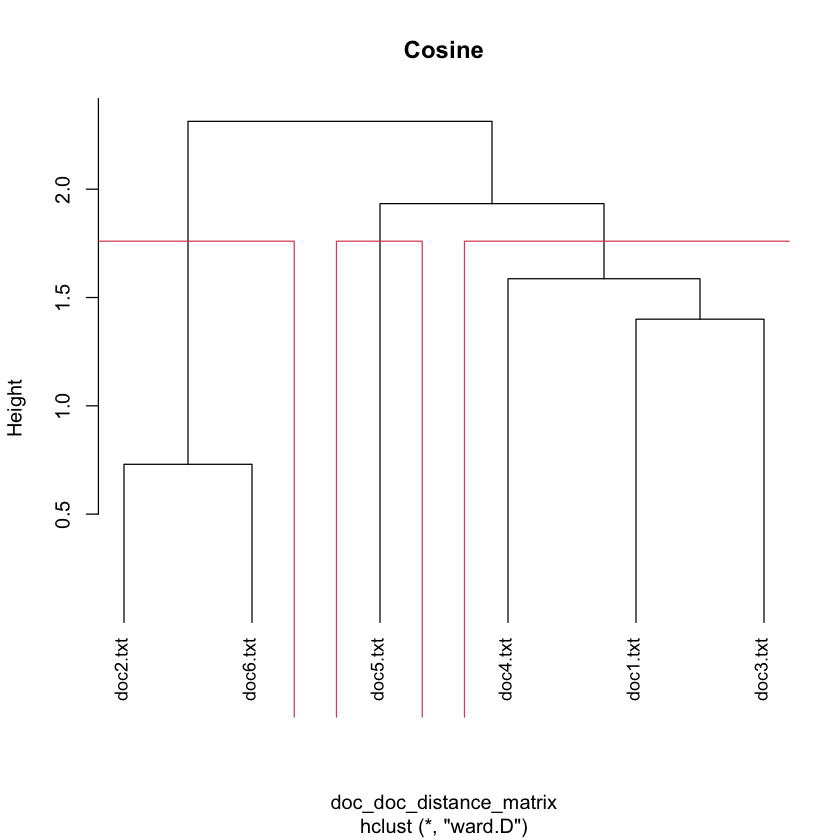

In [281]:
## Manhattan Distance
Corpus_Dist_Manhattan = dist(Corpus_DTM_mat_norm, method = "minkowski", p=1)
(as.matrix(Corpus_Dist_Manhattan))

# Plot dendrogram
find_hclust(Corpus_Dist_Manhattan, linkage="ward.D", title="Cosine", n_clusters=3, hang=-30)

,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
doc1.txt,0.0000000,0.4485532,0.4427189,0.3831449,0.4573839,0.4194043
doc2.txt,0.4485532,0.0000000,0.4485532,0.3857460,0.4690416,0.2551470
doc3.txt,0.4427189,0.4485532,0.0000000,0.4113393,0.4573839,0.4194043
doc4.txt,0.3831449,0.3857460,0.4113393,0.0000000,0.4009988,0.3502856
doc5.txt,0.4573839,0.4690416,0.4573839,0.4009988,0.0000000,0.4348563
doc6.txt,0.4194043,0.2551470,0.4194043,0.3502856,0.4348563,0.0000000


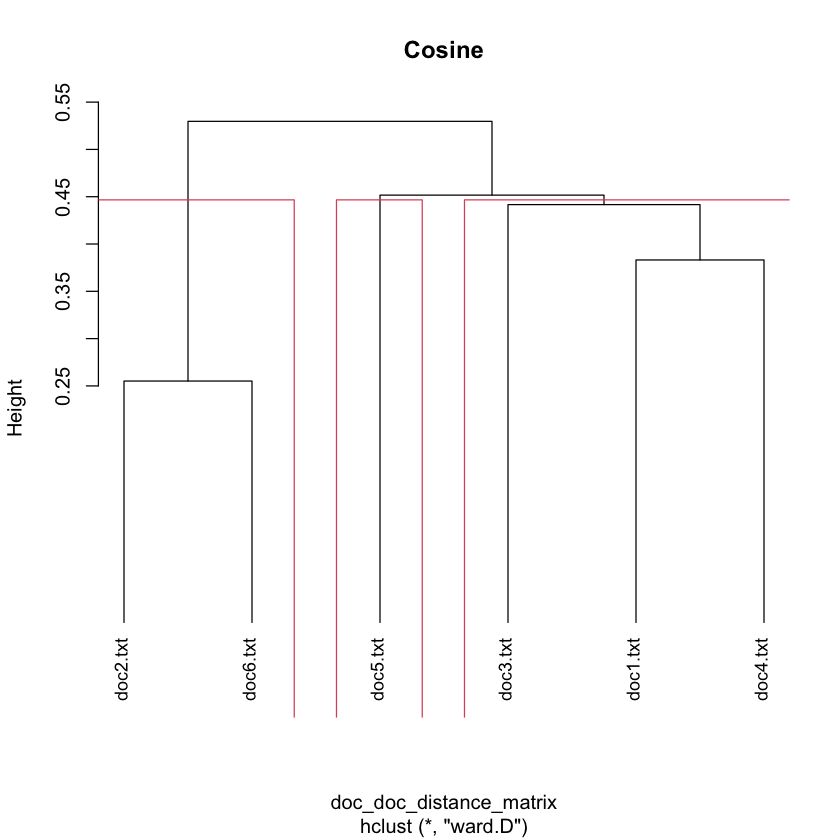

In [282]:
## Euclidean
Corpus_Dist_Euclidean = dist(Corpus_DTM_mat_norm, method = "minkowski", p=2)
(as.matrix(Corpus_Dist_Euclidean))

# Plot dendrogram
find_hclust(Corpus_Dist_Euclidean, linkage="ward.D", title="Cosine", n_clusters=3, hang=-30)

Cosine Similarity Matrix:

,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
doc1.txt,1.0000000,0.2182179,0.2857143,0.32732684,0.11952286,0.2279212
doc2.txt,0.2182179,1.0000000,0.2182179,0.25000000,0.00000000,0.6963106
doc3.txt,0.2857143,0.2182179,1.0000000,0.21821789,0.11952286,0.2279212
doc4.txt,0.3273268,0.2500000,0.2182179,1.00000000,0.09128709,0.2611165
doc5.txt,0.1195229,0.0000000,0.1195229,0.09128709,1.00000000,0.0000000
doc6.txt,0.2279212,0.6963106,0.2279212,0.26111648,0.00000000,1.0000000


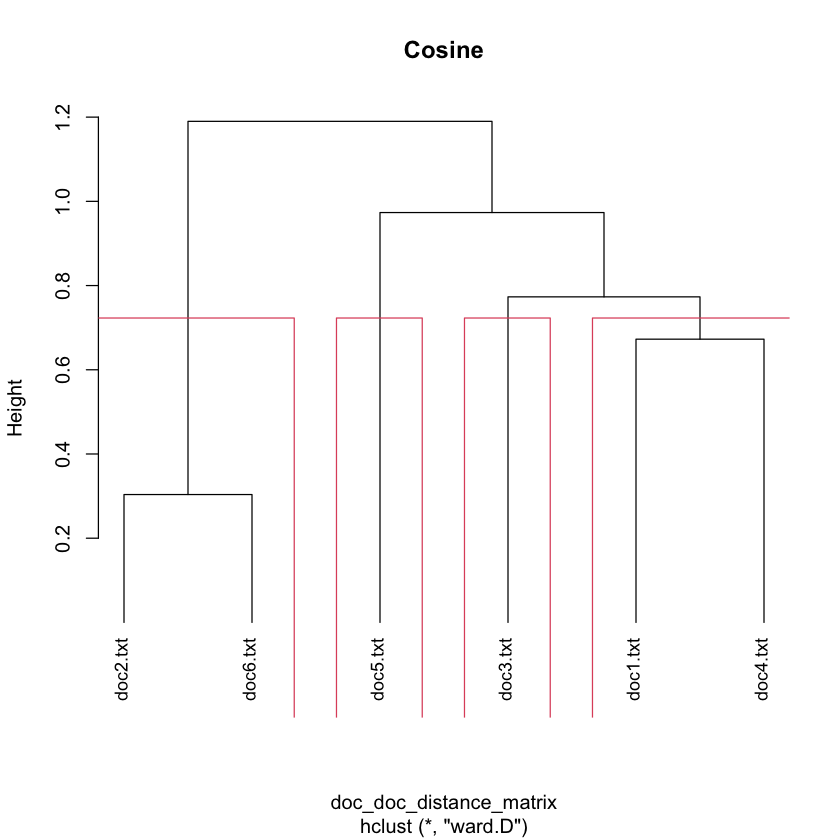

In [283]:
## Cosine
## a * b / (||a|| * ||b||)

#### Document-Document Cosine Similarity
Corpus_Sim_Cosine = Corpus_DTM_mat_norm / sqrt(rowSums(Corpus_DTM_mat_norm * Corpus_DTM_mat_norm))
Corpus_Sim_Cosine = Corpus_Sim_Cosine %*% t(Corpus_Sim_Cosine)    ## Important
cat("Cosine Similarity Matrix:")
(as.matrix(Corpus_Sim_Cosine))

# Convert to cosine-distance metric
Corpus_Dist_Cosine = as.dist(1 - Corpus_Sim_Cosine)

# Plot dendrogram
find_hclust(Corpus_Dist_Cosine, linkage="ward.D", title="Cosine", n_clusters=4, hang=-11)


#### Vocab Cosine Similarity
# Corpus_Dist_Cosine = distance(as.matrix(scale(t(Corpus_DTM_DF))), method="cosine",use.row.names = TRUE)
# Corpus_Dist_Cosine = as.dist(Corpus_Dist_Cosine)
# (as.matrix(Corpus_Dist_Cosine))
# find_hclust(Corpus_Dist_Cosine, linkage="ward.D", title="Cosine", n_clusters=3, hang=-1)

----

----

# Project Clustering in R

## Imports

In [2]:
library(stats)
library(NbClust)
library(cluster)
library(mclust)
library(amap)
library(factoextra)
library(purrr)
#library(stylo)
library(philentropy)
library(SnowballC)
library(caTools)
library(dplyr)
library(textstem)
library(stringr)
library(wordcloud)
library(tm)
library(ggplot2)
library(readr)
library(stringr)
library(igraph)
library(networkD3)

## Dataset

In [3]:
# original dataset
data <- read_csv('../data/processed_cuboulder_TwitterData.csv')

# considering **only** the cleaned text column
data = data[c("Processed_tweet")]

head(data,2)

Rows: 3394 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): dateMonthYear, tweet, lang, username, tweet_url, hastags, topic, ...
dbl  (10): dateDay, dateMonth, dateYear, retweetCount, likeCount, replyCount...
lgl   (1): verifiedStatus
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Processed_tweet
<chr>
campus dining location close today jan 1 happy new year full list break hour location
what your campus dining option today jan 2 alferd packer grill open 7 2 30 pm bakery open 7 3 pm full list break hour location


In [4]:
#### Converting CSV(Text_column) to a Corpus object

## 1) Create a column with the row numbers
df = cbind(doc_id=sprintf("UID_%s", seq(1: nrow(data))), data)
## 2) Make sure the DF has the EXACT column names of "doc_id" and "text":
colnames(df) = c("doc_id", "text") 
## Check it
head(df)
# Create a corpus obj
Corpus = Corpus(DataframeSource(df))
cat("Number of documents: ", length(Corpus))

# OR,
#tweets <- as.character(data$Processed_tweet)
#Corpus <- Corpus(VectorSource(tweets))

,doc_id,text
,<chr>,<chr>
1,UID_1,campus dining location close today jan 1 happy new year full list break hour location
2,UID_2,what your campus dining option today jan 2 alferd packer grill open 7 2 30 pm bakery open 7 3 pm full list break hour location
3,UID_3,fpga design embed system soc verilog vlsi asic semiconductor semicon electronics hardware hdl technology sram intel quartus altera xilinix microsemi system chip architecture coursera elearne course certification course cuboulder
4,UID_4,what your campus dining option today jan 3 alferd packer grill open 7 2 30 pm bakery open 7 3 pm full list break hour location
5,UID_5,anthro phd student m frequently ask why study drone past month alone coloradodrone recent drone strike ve see need well understand societal impact drone tech why m excited continue research
6,UID_6,true false concussion college student significantly likely occur play field new research which look student health datum show surprising result read


Number of documents:  3394

## Basic Preprocessing

In [5]:
# already preprocessed!

# corpus <- tm_map(corpus, content_transformer(tolower))
# corpus <- tm_map(corpus, removePunctuation)
# corpus <- tm_map(corpus, removeWords, stopwords("english"))
# corpus <- tm_map(corpus, lemmatize_strings)

## Document-Term and Term-Doc Matrices

In [5]:
## ----------------------------------------------------------------------------------------
## DOCUMENT Term Matrix  (Docs are rows)
## ----------------------------------------------------------------------------------------
Corpus_DTM <- DocumentTermMatrix(
    Corpus,
    control = list(stopwords = TRUE, ## remove normal stopwords
                   wordLengths=c(5, 10), ## get rid of words of len 2 or smaller or larger than 15
                   removePunctuation = TRUE,
                   removeNumbers = TRUE,
                   tolower=TRUE
                   #stemming = TRUE,
                  ))

# matrix
Corpus_DTM_mat = data.matrix(Corpus_DTM)

# data-frame
Corpus_DTM_DF = data.frame(Corpus_DTM_mat)

#inspect(Corpus_DTM)
#(Corpus_DTM_mat)
Corpus_DTM_DF

,break.,campus,close,dining,happy,location,today,alferd,bakery,grill,⋯,saver,typical,soulor,eject,immunology,oncologia,oncologist,oncology,sarcoma,tragedy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UID_1,1,1,1,1,1,2,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_2,1,1,0,1,0,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
UID_3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_4,1,1,0,1,0,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
UID_5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UID_9,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
## ----------------------------------------------------------------------------------------
## TERM Document Matrix  (words are rows)
## ----------------------------------------------------------------------------------------
Corpus_TDM <- TermDocumentMatrix(
    Corpus,
    control = list(
        stopwords = TRUE, ## remove normal stopwords
        wordLengths=c(3, 10), ## get rid of words of len 2 or smaller or larger than 15
        removePunctuation = TRUE,
        removeNumbers = TRUE,
        tolower=TRUE
        #stemming = TRUE,
        ))

# matrix
Corpus_TDM_mat = data.matrix(Corpus_TDM)

# data-frame
Corpus_TDM_DF <- data.frame(Corpus_TDM_mat)

#inspect(Corpus_TDM)
#(Corpus_TDM_mat)
Corpus_TDM_DF

,UID_1,UID_2,UID_3,UID_4,UID_5,UID_6,UID_7,UID_8,UID_9,UID_10,⋯,UID_3385,UID_3386,UID_3387,UID_3388,UID_3389,UID_3390,UID_3391,UID_3392,UID_3393,UID_3394
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
break,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
campus,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
close,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
dining,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
full,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
happy,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
hour,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
jan,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
list,1,1,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0


In [7]:
## ----------------------------------------------------------------------------------------
## VOCABULARY
## ----------------------------------------------------------------------------------------
vocab = unique(Corpus_DTM$dimnames$Terms)
cat("Vocabulary Dimensions (number of unique words): ", length(vocab))

Vocabulary Dimensions (number of unique words):  5868

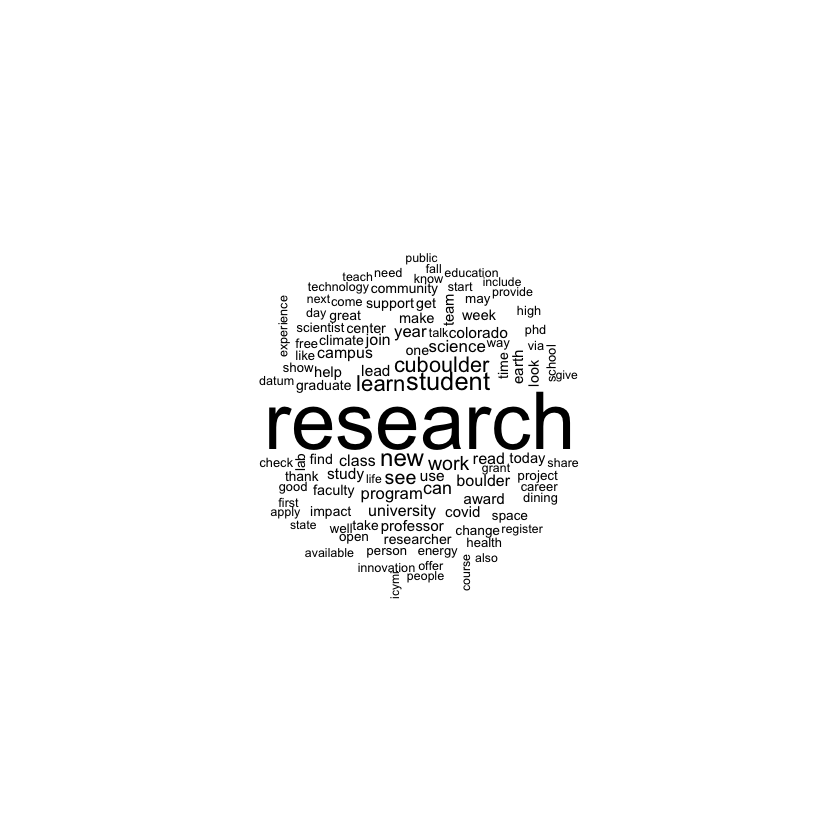

In [8]:
## ----------------------------------------------------------------------------------------
## WORDCLOUD
## ----------------------------------------------------------------------------------------
word.freq <- sort(rowSums(Corpus_TDM_mat), decreasing = T)
top_100_words = word.freq[1:100]
wordcloud(words = names(top_100_words), freq = top_100_words*2, min.freq = 2, random.order = F)

In [9]:
## ----------------------------------------------------------------------------------------
## Get Frequencies and sums
## ----------------------------------------------------------------------------------------
CorpusWordFreq <- colSums(Corpus_DTM_mat)
ord <- order(CorpusWordFreq)

## Word count in each row (doc)
Row_Sum_Per_doc <- rowSums((Corpus_DTM_mat))  

## Normalization
## - Create your own normalization function to divide the frequency of each word in each row 
##   by the sum of the words in that row, using Doc-term-matrix.
Corpus_DTM_mat_norm <- apply(Corpus_DTM_mat, 1, function(i) round(i/sum(i),2))
Corpus_DTM_mat_norm

,UID_1,UID_2,UID_3,UID_4,UID_5,UID_6,UID_7,UID_8,UID_9,UID_10,⋯,UID_3385,UID_3386,UID_3387,UID_3388,UID_3389,UID_3390,UID_3391,UID_3392,UID_3393,UID_3394
break,0.12,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
campus,0.12,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
close,0.12,0.0,0.00,0.0,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
dining,0.12,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
happy,0.12,0.0,0.00,0.0,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
location,0.25,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
today,0.12,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
alferd,0.00,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
bakery,0.00,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0
grill,0.00,0.1,0.00,0.1,0.00,0,0,0,0,0.00,⋯,0,0,0.00,0.00,0,0.00,0,0,0,0


## Hierarchical clustering

In [10]:
find_hclust <- function(doc_doc_distance_matrix, linkage, title, n_clusters, hang=-1){
    
    ## Running hierarchial clustering using `hclust`....
    ## Linkages - Ward, Ward.D2, complete, etc..
    HClust_Corpus = hclust(doc_doc_distance_matrix, method = linkage)

    ## Plot Dendrogram....
    plot(HClust_Corpus, cex=0.9, hang=hang, main=title)
    rect.hclust(HClust_Corpus, k=n_clusters)
}

In [11]:
# Based on heuristics, 
n_clusters = 85

##### Distance Metrics between documents

In [ ]:
## Euclidean
Corpus_Dist_Euclidean = dist(Corpus_DTM_DF, method = "minkowski", p=2)
(as.matrix(Corpus_Dist_Euclidean))

# Plot dendrogram
find_hclust(Corpus_Dist_Euclidean, linkage="ward.D", title="Cosine", n_clusters=3, hang=-30)

Cosine Similarity Matrix:

,doc1.txt,doc2.txt,doc3.txt,doc4.txt,doc5.txt,doc6.txt
doc1.txt,1.0000000,0.2182179,0.2857143,0.32732684,0.11952286,0.2279212
doc2.txt,0.2182179,1.0000000,0.2182179,0.25000000,0.00000000,0.6963106
doc3.txt,0.2857143,0.2182179,1.0000000,0.21821789,0.11952286,0.2279212
doc4.txt,0.3273268,0.2500000,0.2182179,1.00000000,0.09128709,0.2611165
doc5.txt,0.1195229,0.0000000,0.1195229,0.09128709,1.00000000,0.0000000
doc6.txt,0.2279212,0.6963106,0.2279212,0.26111648,0.00000000,1.0000000


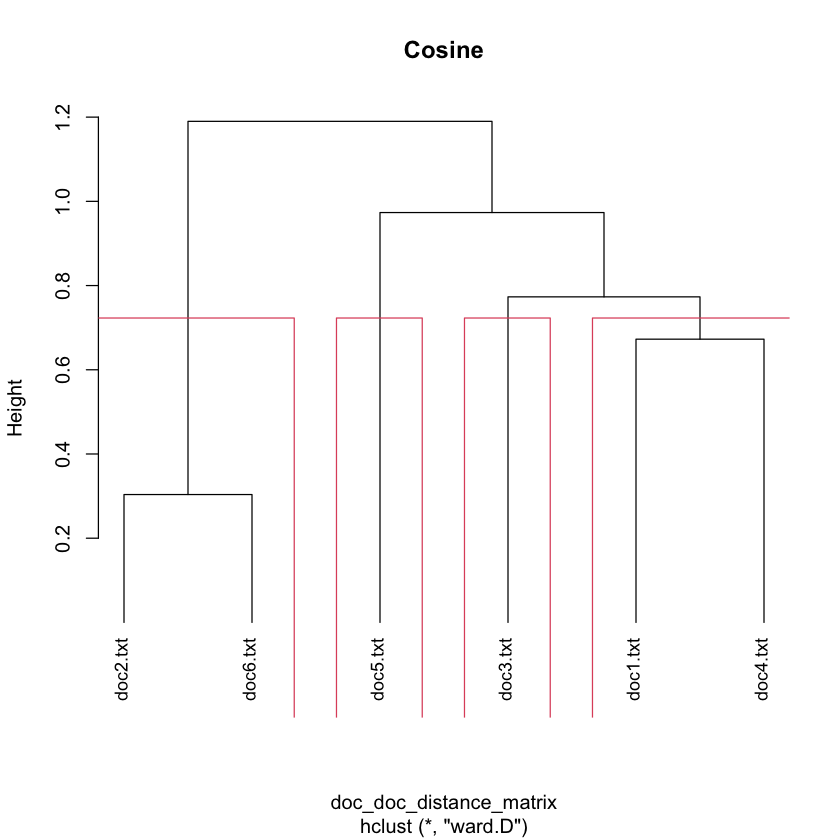

In [242]:
## Cosine
## a * b / (||a|| * ||b||)

#### Document-Document Cosine Similarity
Corpus_Sim_Cosine = Corpus_DTM_mat / sqrt(rowSums(Corpus_DTM_mat * Corpus_DTM_mat))
Corpus_Sim_Cosine = Corpus_Sim_Cosine %*% t(Corpus_Sim_Cosine)    ## Important
cat("Cosine Similarity Matrix:")
(as.matrix(Corpus_Sim_Cosine))

# Convert to distance metric
Corpus_Dist_Cosine = as.dist(1 - Corpus_Sim_Cosine)

# Plot dendrogram
find_hclust(Corpus_Dist_Cosine, linkage="ward.D", title="Cosine", n_clusters=4, hang=-11)


#### Vocab Cosine Similarity
# Corpus_Dist_Cosine = distance(as.matrix(scale(t(Corpus_DTM_DF))), method="cosine",use.row.names = TRUE)
# Corpus_Dist_Cosine = as.dist(Corpus_Dist_Cosine)
# (as.matrix(Corpus_Dist_Cosine))
# find_hclust(Corpus_Dist_Cosine, linkage="ward.D", title="Cosine", n_clusters=3, hang=-1)

----